# Convolutional Neural Network for GDP Time Series Forecasting

## Table of Contents

1. Load packages and data
2. Prepare data for training
3. Create baseline model
4. Hyperparameter Tuning

## Load packages and data

In [1]:
# load relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import pydot

In [2]:
# load cleaned data
data = pd.read_csv('data_cleaned.csv', index_col=0)

data

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Merchandise Imports By Commodity Division | Total Merchandise Imports,M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,Domestic Exports Of Major Non-Oil Products | Total Electronic Products,Composite Leading Index (2015 = 100) | Quarterly Composite Leading Index,"Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total",Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate
Period,,,,,,,,,,,,,,,
1997-01-31,5.766667,111.147,15.715098,5.488212,93891.4,1.600448,9.938033,-5.407013,-0.636598,2.039052,5.333333,-4.953253,4.805478,-6.735186,-14.074074
1997-02-28,5.733333,109.571,-19.711470,0.511269,95647.4,-11.022186,6.894096,-3.535354,-5.900391,2.393572,3.666667,-1.013923,6.974227,-5.116564,-17.037037
1997-03-31,5.700000,118.447,3.658993,16.211454,94048.8,1.893330,9.790800,-6.288319,-5.065484,2.748092,2.000000,2.925407,9.142976,-3.497942,-20.000000
1997-04-30,6.966667,107.974,2.971000,9.481268,94470.6,2.179168,4.434663,2.294903,-1.744494,3.147185,8.666667,6.860232,10.549475,-3.759513,-20.277778
1997-05-31,8.233333,113.795,2.081662,7.937089,94257.8,6.845282,5.632341,0.208366,-7.157538,3.546278,15.333333,10.795056,11.955975,-4.021084,-20.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,2.733333,94.672,3.528764,-6.174603,99219.0,-0.041443,3.938170,-3.701242,-20.219001,-3.943664,5.000000,-2.638300,1.877809,-5.648494,-16.190476
2022-12-31,2.100000,102.994,4.257838,-1.193731,99029.0,-8.242208,6.151695,-3.505964,-17.856474,-5.422222,3.000000,-0.911467,1.223659,-9.912281,-14.285714
2023-01-31,1.533333,99.578,-4.899654,-4.905048,85680.0,-11.227587,6.068394,-3.013121,-26.816758,-5.461702,3.333333,2.834411,0.420000,-5.828636,-16.190476


## Prepare data for training

In this section, we will prepare the data for the 1D CNN by 
1. normalizing the data
2. prepare the time sequence with a lookback 6 (6 months) to perform 1 step prediction (1 month)
3. Train test split

In [88]:
target = 'Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars'

#Normalize the data
X = data.drop([target],axis=1).values
X_train = X[:253]
X_test = X[253:]
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X = np.concatenate((X_train, X_test), axis=0)
y=np.expand_dims(data[target].values,1)

In [4]:
def convert2matrix(X_arr, Y_arr, lookback):
    X, Y = [], []
    # iterating through the data with window as look back
    for i in range(len(X_arr) - lookback):
        d = i + lookback
        # extracting the X as features and target of n days and Y as target at (n+1)th day
        X.append(np.hstack((X_arr[i:d], Y_arr[i:d])))
        # X.append(X_arr[i:d])
        Y.append(Y_arr[d])
    return np.array(X), np.array(Y)


#prepare inputs for model
lookback = 6
x,y = convert2matrix(X,y,lookback)

In [5]:
#split train, test dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(247, 6, 15) (247, 1)
(62, 6, 15) (62, 1)


In [89]:
lookback = 12
x2,y2 = convert2matrix(X,y,lookback)

X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, shuffle=False)
print(X_train2.shape,y_train2.shape)
print(X_test2.shape,y_test2.shape)

(242, 12, 15) (242, 1)
(61, 12, 15) (61, 1)


## Create baseline CNN

In this section, we will create a baseline CNN with a single Conv1D layer.

Note that it is possible to add more layers however, we will have to consider a longer lookback period. eg. lookback (12 months) for 1 step prediction.

In [9]:
class CNNModel:
    def __init__(self, conv_filters=32, kernel_size=6, dense_units=32, learning_rate =0.001):

        self.model = tf.keras.Sequential()

        self.model.add(tf.keras.layers.Conv1D(filters=conv_filters,
                                              kernel_size=(kernel_size,),
                                              activation="relu"))
        self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) 
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=dense_units, activation="relu"))
        self.model.add(tf.keras.layers.Dense(units=1))
        self.learning_rate = learning_rate


    def fit(self, X_train, 
            y_train, 
            epochs=400, 
            batch_size=10, 
            validation_split=0.1, 
            verbose=1,      
            shuffle=False, 
            callbacks=None):

        self.model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            metrics=[tf.keras.metrics.MeanAbsoluteError()],
        )

        history = self.model.fit(
            X_train, y_train, epochs=epochs, batch_size=batch_size, 
            validation_split=validation_split, verbose=verbose, 
            shuffle=shuffle, callbacks=callbacks
        )

        return history

    def evaluate(self, eval_data, verbose=0):

        mse, mae = self.model.evaluate(eval_data, verbose=verbose)

        return mse, mae

    def predict(self, pred_data):
        return self.model.predict(pred_data)
    
    def summary(self):
        self.model.summary()    


In [91]:
class DeepCNNModel:
    def __init__(self, conv_filters=[16,32,64], kernel_size=3, dense_units=32, learning_rate =0.001):

        self.model = tf.keras.Sequential()

        self.model.add(tf.keras.layers.Conv1D(filters=conv_filters[0],
                                              kernel_size=(kernel_size,),
                                              activation="relu"))
        self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) 
        self.model.add(tf.keras.layers.Conv1D(filters=conv_filters[1],
                                              kernel_size=(kernel_size,),
                                              activation="relu"))
        self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))   
        # self.model.add(tf.keras.layers.Conv1D(filters=conv_filters[2],
        #                                       kernel_size=(kernel_size,),
        #                                       activation="relu"))
        # self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))         
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=dense_units, activation="relu"))
        self.model.add(tf.keras.layers.Dense(units=1))
        self.learning_rate = learning_rate


    def fit(self, X_train, 
            y_train, 
            epochs=400, 
            batch_size=10, 
            validation_split=0.1, 
            verbose=1,      
            shuffle=False, 
            callbacks=None):

        self.model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            metrics=[tf.keras.metrics.MeanAbsoluteError()],
        )

        history = self.model.fit(
            X_train, y_train, epochs=epochs, batch_size=batch_size, 
            validation_split=validation_split, verbose=verbose, 
            shuffle=shuffle, callbacks=callbacks
        )

        return history

    def evaluate(self, eval_data, verbose=0):

        mse, mae = self.model.evaluate(eval_data, verbose=verbose)

        return mse, mae

    def predict(self, pred_data):
        return self.model.predict(pred_data)
    
    def summary(self):
        self.model.summary()    


In [20]:
conv_filters = 32
kernel_size = 3
dense_units =32

# Set the random seed for TensorFlow
tf.random.set_seed(42)

# Set the random seed for numpy
np.random.seed(42)

model_baseline = CNNModel(conv_filters=conv_filters, 
                          kernel_size=kernel_size,
                          dense_units=dense_units)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model_baseline.fit(X_train, y_train, 
                             epochs=400, 
                             batch_size=10, 
                             validation_split=0.1, 
                             verbose=1, 
                             shuffle=False, 
                             callbacks=[early_stop])

Epoch 1/400
23/23 [==============================] - 0s 5ms/step - loss: 25.4190 - mean_absolute_error: 4.2146 - val_loss: 2.5479 - val_mean_absolute_error: 1.4954
Epoch 2/400
23/23 [==============================] - 0s 2ms/step - loss: 9.2223 - mean_absolute_error: 2.4301 - val_loss: 0.4375 - val_mean_absolute_error: 0.5050
Epoch 3/400
23/23 [==============================] - 0s 2ms/step - loss: 7.3289 - mean_absolute_error: 2.0799 - val_loss: 0.4141 - val_mean_absolute_error: 0.4980
Epoch 4/400
23/23 [==============================] - 0s 2ms/step - loss: 6.2603 - mean_absolute_error: 1.9612 - val_loss: 0.3889 - val_mean_absolute_error: 0.4930
Epoch 5/400
23/23 [==============================] - 0s 2ms/step - loss: 5.0422 - mean_absolute_error: 1.7685 - val_loss: 0.4449 - val_mean_absolute_error: 0.5299
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 3.9779 - mean_absolute_error: 1.5938 - val_loss: 0.4202 - val_mean_absolute_error: 0.5088
Epoch 7/400
23/23 [==

In [21]:
model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 32)             1472      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
____________________________________________________

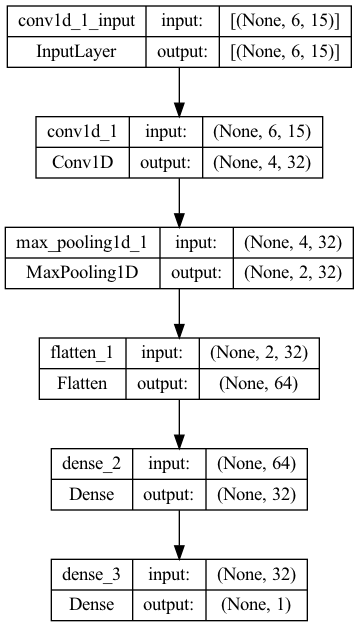

In [13]:
img_file = "./cnn_baseline.png"
tf.keras.utils.plot_model(model_baseline.model, to_file=img_file, show_shapes=True, show_layer_names=True)

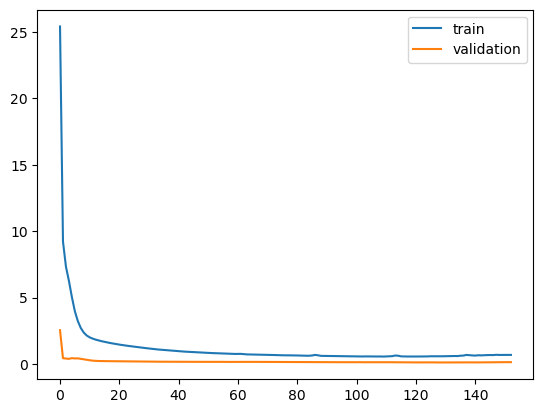

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

2/2 [==============================] - 0s 2ms/step


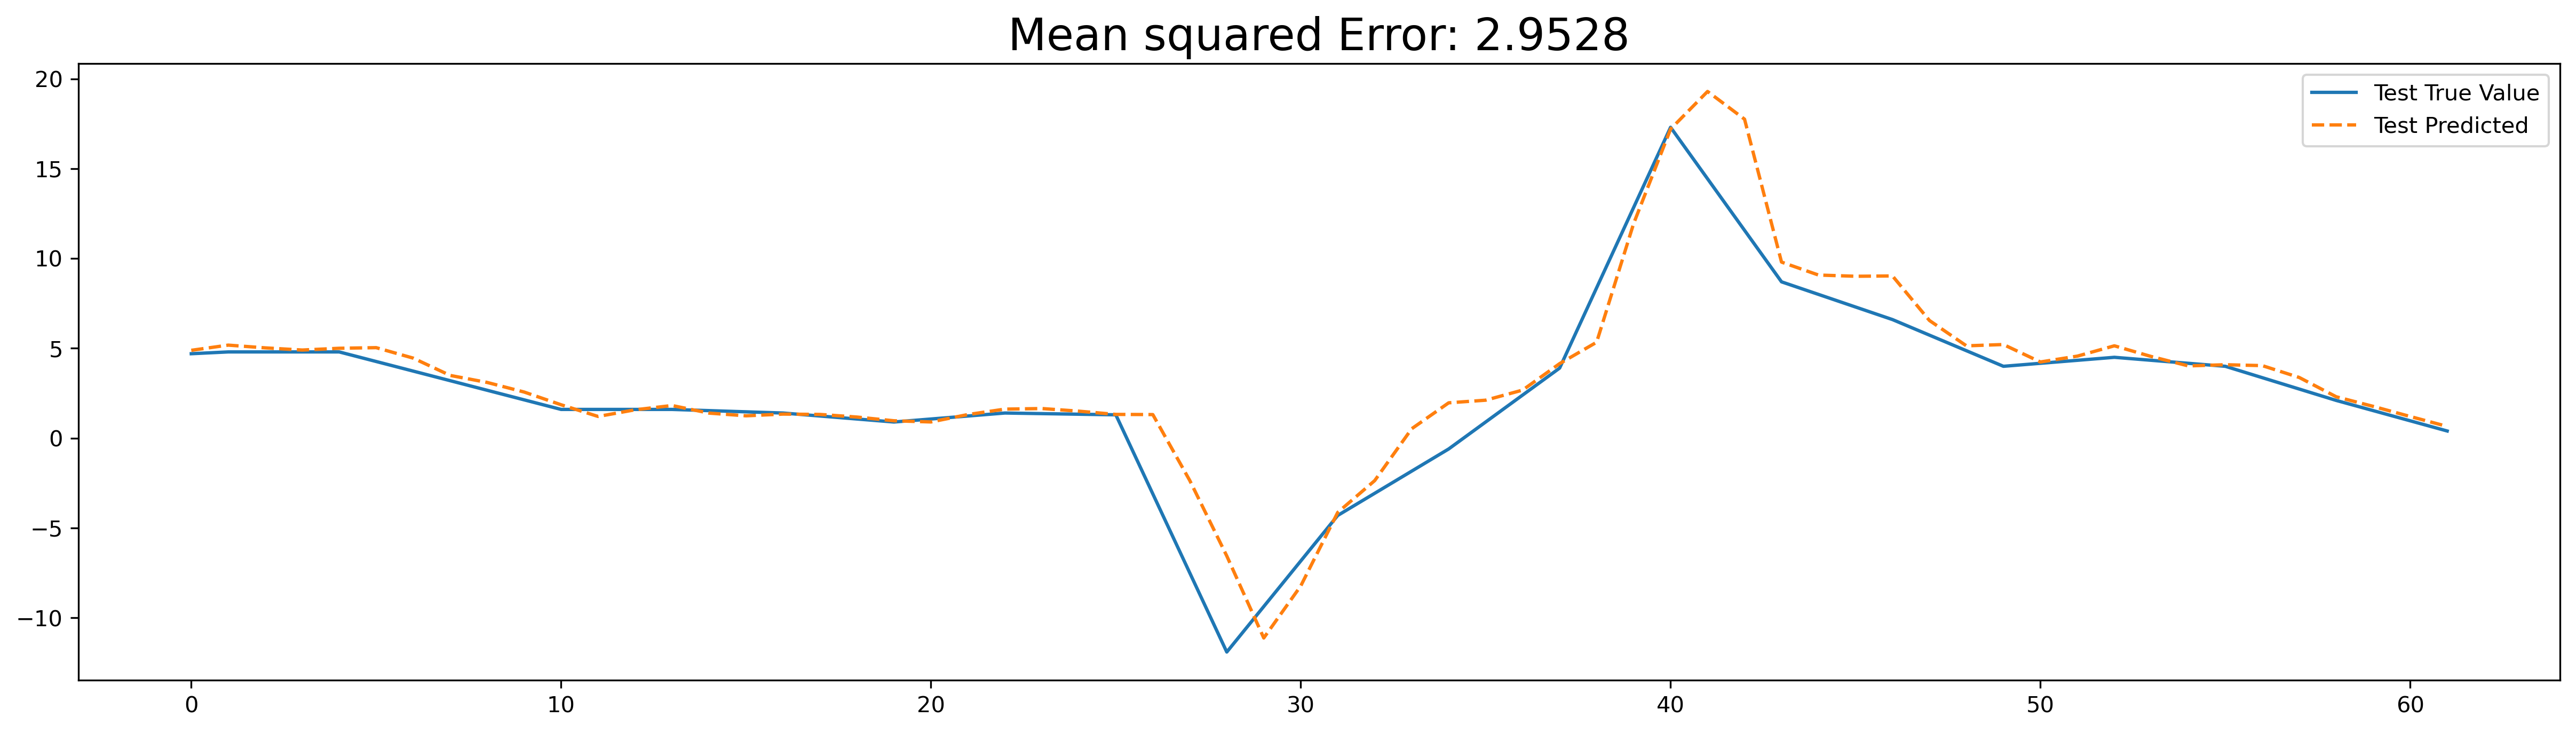

In [23]:
pred = model_baseline.predict(X_test)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='Test True Value')
plt.plot(pred,linestyle='--', label = 'Test Predicted')
plt.legend()
plt.title('Mean squared Error: '+str(mean_squared_error(pred,y_test))[:6],fontsize=20)
plt.show()

8/8 [==============================] - 0s 2ms/step


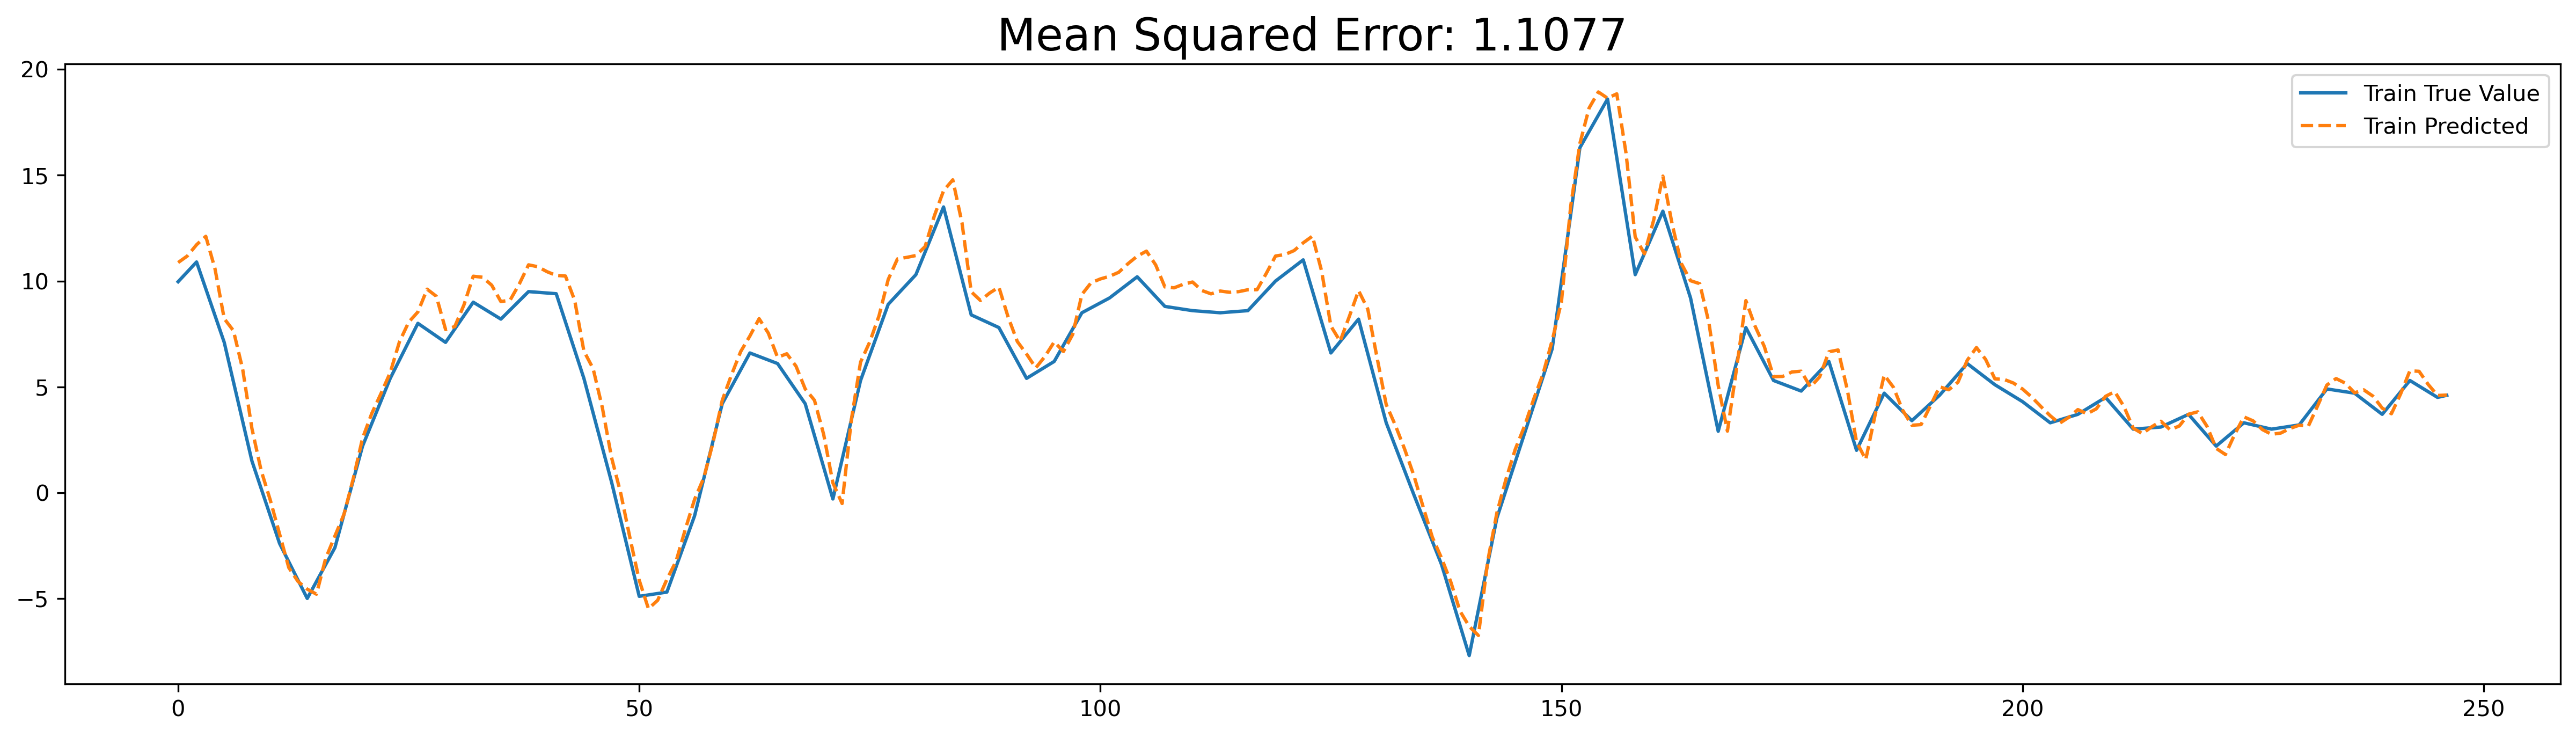

In [24]:
pred_train = model_baseline.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='Train True Value')
plt.plot(pred_train,linestyle='--', label = 'Train Predicted')
plt.legend()
plt.title('Mean Squared Error: ' + str(mean_squared_error(pred_train,y_train))[:6],fontsize=20)
plt.show()

In [25]:
model_baseline.model.save('./cnn_baseline.h5')

## Multilayer CNN

With longer lookback period, we can construct deeper 1D CNN. In this section, we will build a 3 layer 1D CNN and compare with the baseline above.

In [92]:
conv_filters = [16, 32, 64]
kernel_size = 3
dense_units =32

# Set the random seed for TensorFlow
tf.random.set_seed(42)

# Set the random seed for numpy
np.random.seed(42)

model_deep = DeepCNNModel(conv_filters=conv_filters, 
                          kernel_size=kernel_size,
                          dense_units=dense_units)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history_deep = model_deep.fit(X_train2, y_train2, 
                             epochs=400, 
                             batch_size=10, 
                             validation_split=0.1, 
                             verbose=1, 
                             shuffle=False, 
                             callbacks=[early_stop])

Epoch 1/400
22/22 [==============================] - 0s 5ms/step - loss: 46.7491 - mean_absolute_error: 5.7822 - val_loss: 8.4173 - val_mean_absolute_error: 2.8237
Epoch 2/400
22/22 [==============================] - 0s 2ms/step - loss: 23.6384 - mean_absolute_error: 3.7683 - val_loss: 1.7673 - val_mean_absolute_error: 1.1759
Epoch 3/400
22/22 [==============================] - 0s 2ms/step - loss: 19.8875 - mean_absolute_error: 3.2775 - val_loss: 1.6334 - val_mean_absolute_error: 1.1156
Epoch 4/400
22/22 [==============================] - 0s 2ms/step - loss: 18.0443 - mean_absolute_error: 3.1495 - val_loss: 1.5164 - val_mean_absolute_error: 1.0631
Epoch 5/400
22/22 [==============================] - 0s 2ms/step - loss: 15.5805 - mean_absolute_error: 2.9378 - val_loss: 1.1176 - val_mean_absolute_error: 0.8793
Epoch 6/400
22/22 [==============================] - 0s 2ms/step - loss: 13.7152 - mean_absolute_error: 2.7781 - val_loss: 0.7978 - val_mean_absolute_error: 0.7356
Epoch 7/400
22/2

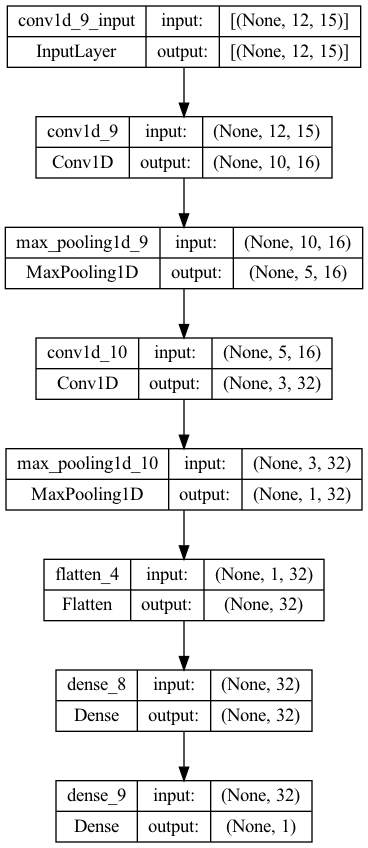

In [94]:
img_file = "./cnn_baseline_deep.png"
tf.keras.utils.plot_model(model_deep.model, to_file=img_file, show_shapes=True, show_layer_names=True)

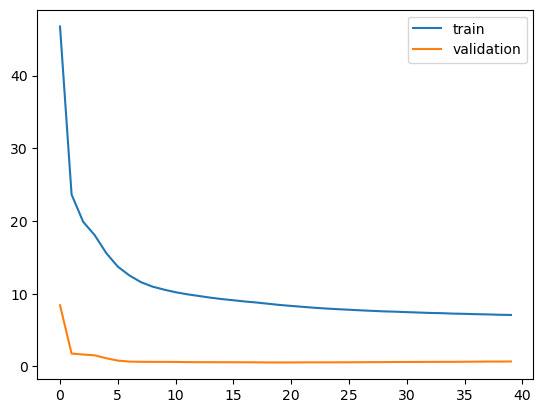

In [95]:
plt.plot(history_deep.history['loss'], label='train')
plt.plot(history_deep.history['val_loss'], label='validation')
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


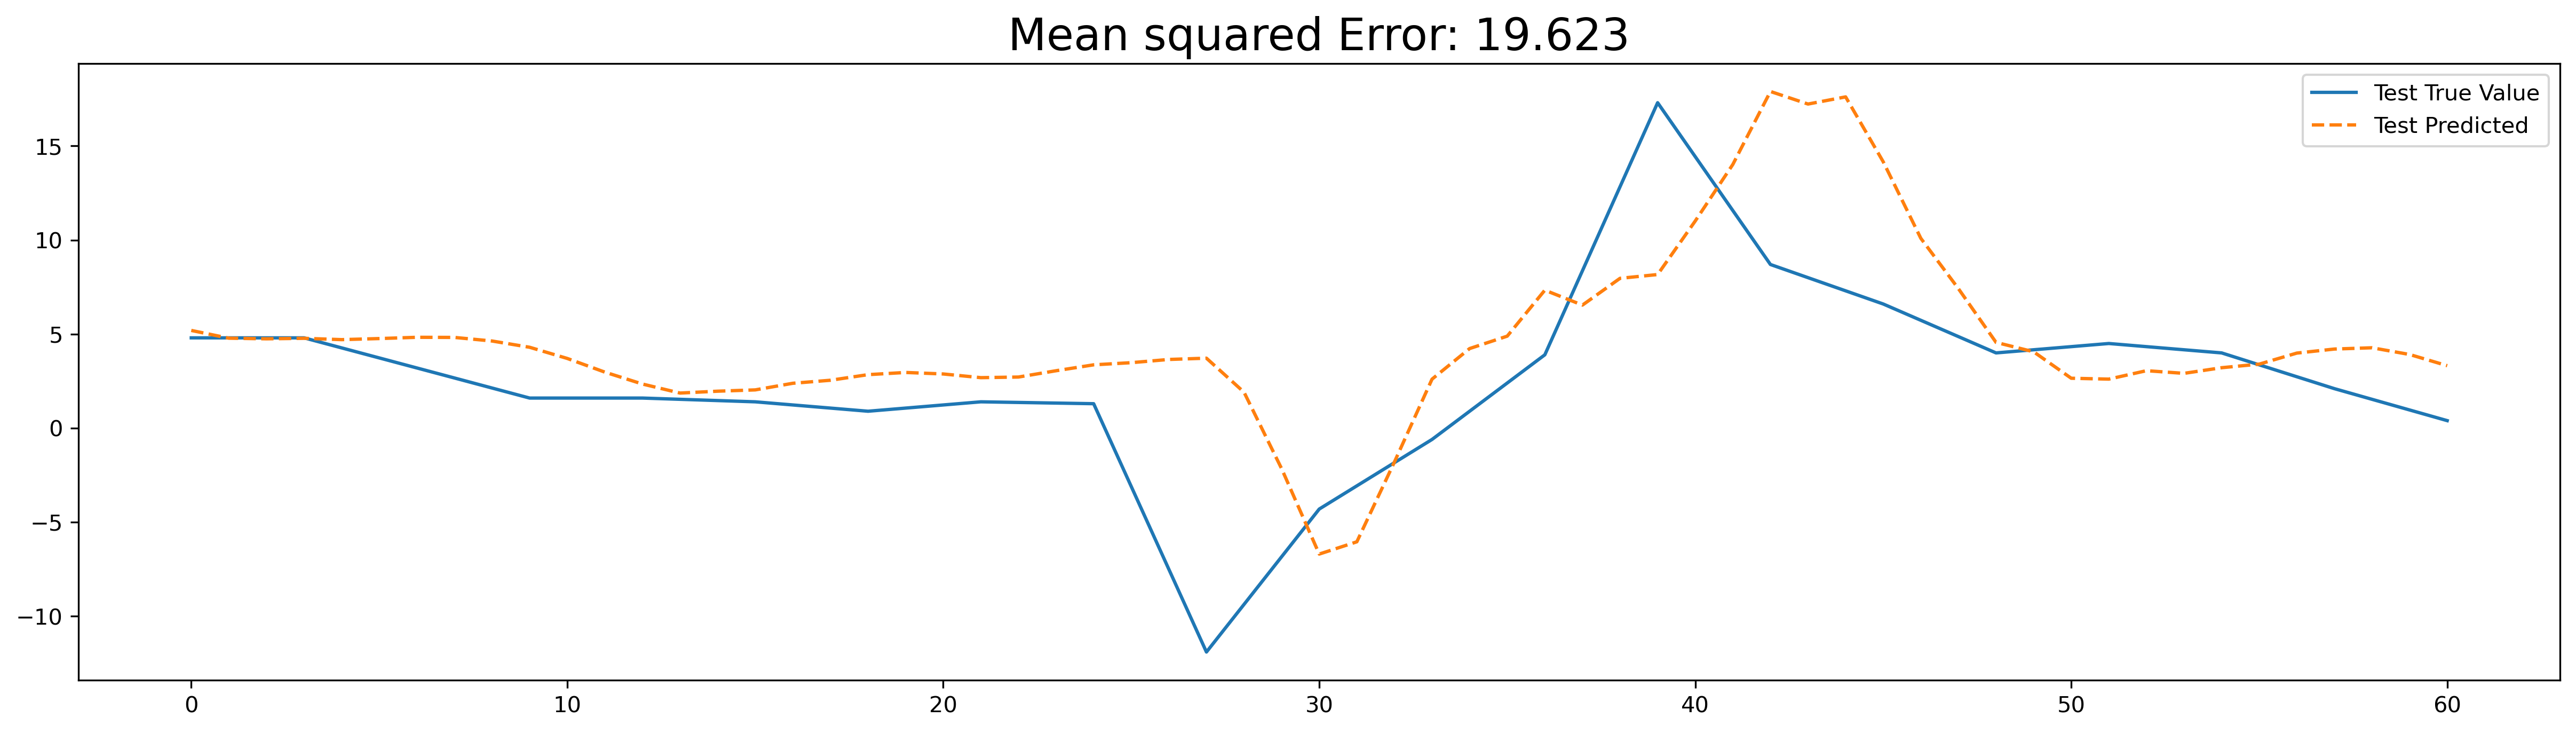

In [96]:
pred2 = model_deep.predict(X_test2)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test2,label='Test True Value')
plt.plot(pred2,linestyle='--', label = 'Test Predicted')
plt.legend()
plt.title('Mean squared Error: '+str(mean_squared_error(pred2,y_test2))[:6],fontsize=20)
plt.show()

8/8 [==============================] - 0s 604us/step


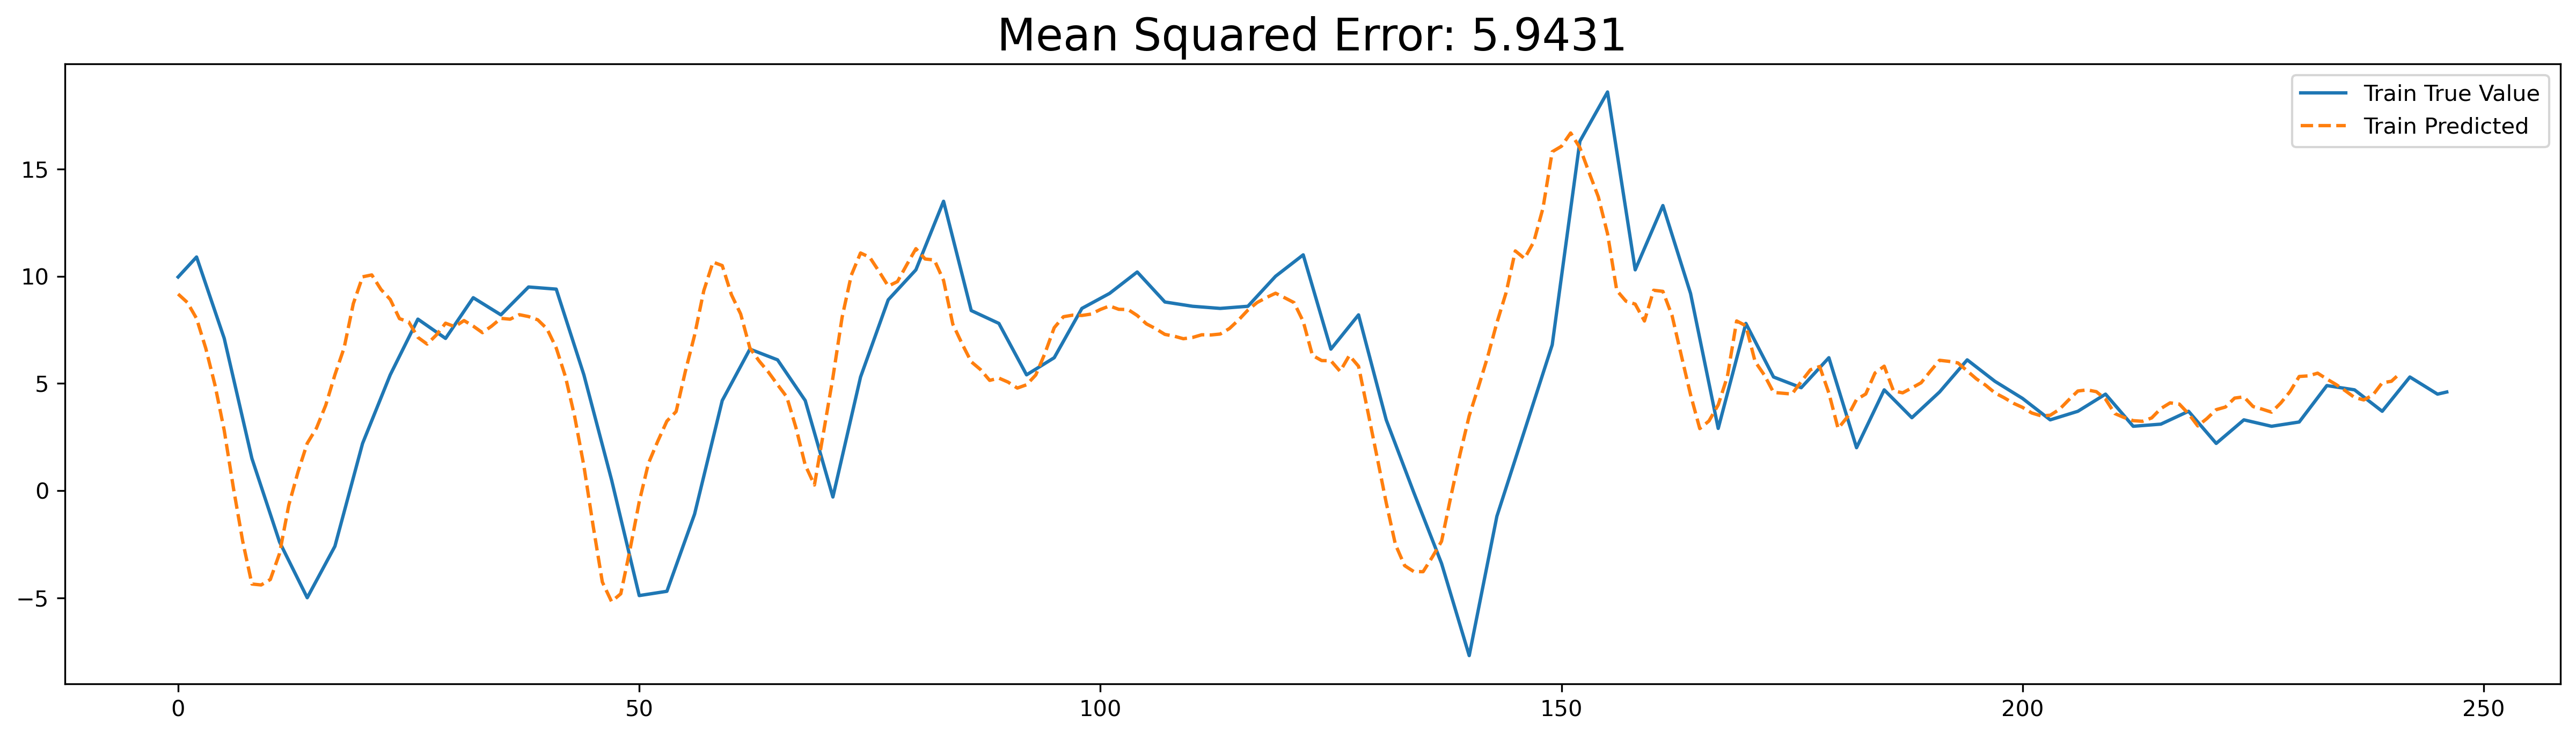

In [97]:
pred_train2 = model_deep.predict(X_train2)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='Train True Value')
plt.plot(pred_train2,linestyle='--', label = 'Train Predicted')
plt.legend()
plt.title('Mean Squared Error: ' + str(mean_squared_error(pred_train2,y_train2))[:6],fontsize=20)
plt.show()

With deeper 1D CNN and longer lookback period, the model seems to perform worse than a simpler architecture. Subsequently, we will perform hyperparameter tuning on the baseline CNN only.

## Hyperparameter Tuning

In this section, we will use Keras Tuner to perform hyperparameter tuning with Bayesian Optimization strategy.

In [26]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=5),
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    return model

In [28]:

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_cnn',
    project_name='CNN'
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=400,
    batch_size=10,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)


Trial 10 Complete [00h 00m 08s]
val_loss: 0.22523431479930878

Best val_loss So Far: 0.0809627075990041
Total elapsed time: 00h 01m 59s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [30]:
best_parameters = tuner.get_best_hyperparameters(1)[0]

In [31]:
best_parameters.values

{'filters': 16,
 'kernel_size': 3,
 'dense_units': 16,
 'learning_rate': 0.006489108709865806}

In [32]:
best_model = tuner.get_best_models()[0]

In [33]:
train_results = best_model.predict(X_train)
test_results = best_model.predict(X_test)

2/2 [==============================] - 0s 949us/step


In [59]:
test_results.shape

(62, 1)

In [71]:
date = data.index
# date = date[6:]
date_train = date[:len(train_results)]
date_test = date[len(train_results):]
test = pd.DataFrame(zip(date_test, test_results, y_test), columns = ['Period','Predicted', 'Actual'])
test['Predicted'] = test['Predicted'].apply(lambda x: float(x))
test['Actual'] = test['Actual'].apply(lambda x: float(x))
test['Period'] = test['Period'].apply(lambda x: x[:7])
test.set_index(test['Period'], inplace = True)

In [72]:
len(test)

62

<AxesSubplot: title={'center': 'Nowcasting GDP using 1D CNN'}, xlabel='Period'>

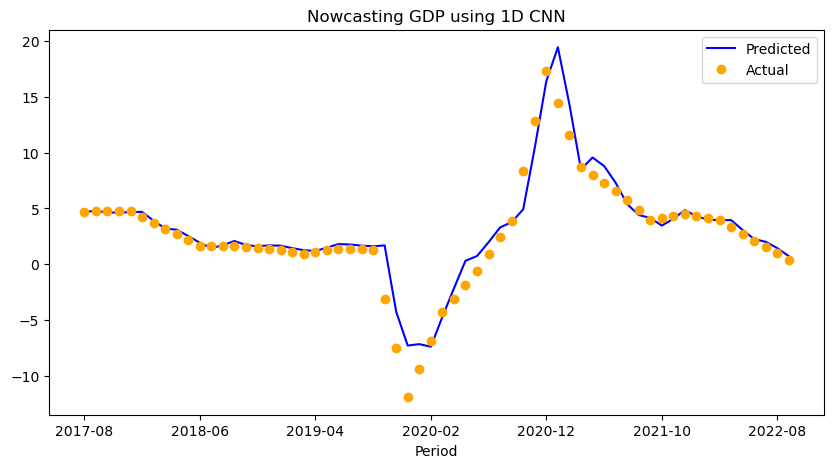

In [73]:
test.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using 1D CNN')

In [54]:
print('RMSE: '+ str(mean_squared_error(test_results,y_test, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results,y_test))[:6])
print('MAE: '+ str(mean_absolute_error(test_results,y_test))[:6])

RMSE: 1.4468
MSE: 2.0933
MAE: 0.8417


In [38]:
best_model.save('./cnn_tuned.h5')

## Model Evaluation

This section loads the trained model for evaluation on the test set.

In [42]:
model_eval1 = tf.keras.models.load_model('./cnn_tuned.h5')

In [43]:
train_results = model_eval1.predict(X_train)
test_results = model_eval1.predict(X_test)

2/2 [==============================] - 0s 8ms/step


<AxesSubplot: title={'center': 'Nowcasting GDP using CNN'}, xlabel='Period'>

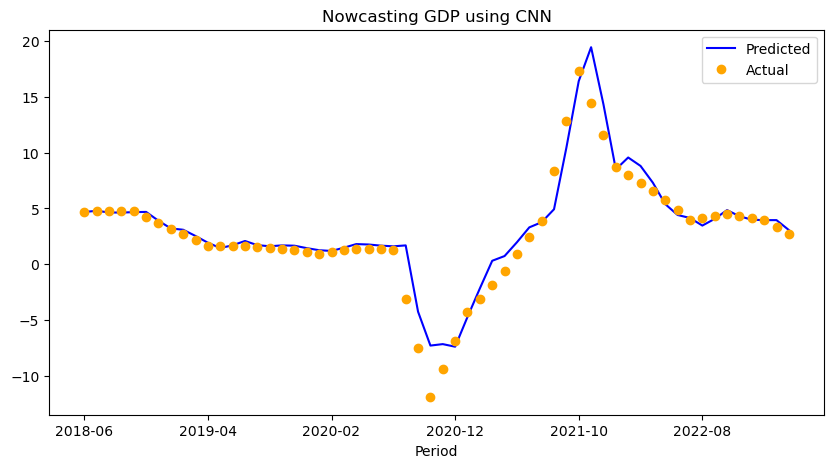

In [46]:
date = data.index
date = date[10:]
date_train = date[:len(train_results)]
date_test = date[len(train_results):]
test = pd.DataFrame(zip(date_test, test_results, y_test), columns = ['Period','Predicted', 'Actual'])
test['Predicted'] = test['Predicted'].apply(lambda x: float(x))
test['Actual'] = test['Actual'].apply(lambda x: float(x))
test['Period'] = test['Period'].apply(lambda x: x[:7])
test.set_index(test['Period'], inplace = True)

test.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using CNN')

In [45]:
print('RMSE: '+ str(mean_squared_error(test_results,y_test, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results,y_test))[:6])
print('MAE: '+ str(mean_absolute_error(test_results,y_test))[:6])

RMSE: 1.4468
MSE: 2.0933
MAE: 0.8417


In [49]:
date

Index(['1997-11-30', '1997-12-31', '1998-01-31', '1998-02-28', '1998-03-31',
       '1998-04-30', '1998-05-31', '1998-06-30', '1998-07-31', '1998-08-31',
       ...
       '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
       '2022-11-30', '2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31'],
      dtype='object', name='Period', length=305)